In [1]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'
TO_MERGE_LOG_PATH = '../dl_logs/to_merge/'




In [2]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9]+)", fold_path)
        fold_nb = int(match.group(1))
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string, end='  ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    if delete_dir: shutil.rmtree(logs_path)
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                if delete_dir: 
                    shutil.rmtree(logs_path)
                    print()
                    return defaultdict(list), dict()
                pass
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_dict = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    hparams_dict.pop('args', None)
        
    return values, hparams_dict

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        
        for steps, vals in zip(x_values, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        
        x_values_flat = [item for x_val in x_values for item in x_val]
        metric_values_flat = [item for val in values[metric_name] for item in val]
        
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        var1 = np.var(temp_lists, axis=0)
        var2 = np.sum((np.array([el - np.mean(temp_lists, axis=0) for el in temp_lists]))**2, axis=0) / len(temp_lists)
        interp_values[f'{metric_name}_interp_var'] = var2
    
    return interp_values, (x_values_flat, metric_values_flat)

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None, values_flat=None, plot_points=False):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])
        
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        
        cutoff = [i for i, n in enumerate(mean_val) if n > 0.99]
        if len(cutoff) < 50:
            cutoff = -1
        else:
            cutoff=cutoff[49]
            
        epochs, mean_val,var_val = epochs[:cutoff], mean_val[:cutoff],var_val[:cutoff]
        
        if plot_points and 'acc' in metric_name and values_flat:
            ax[i].scatter(values_flat[0], values_flat[1], color=color, marker='o', s=3, alpha=0.25)
        p=ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val) 
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor=p[-1].get_color())
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(len(epochs)) * 0.95, '--k', linewidth=1, alpha=0.6)
        
    return ax

def create_run_dict(hparams_dict, metric_values, ckpt_name):
    hparams_dict['name'] = ckpt_name
    hparams_dict['eval_steps'] = []
    hparams_dict['best_score'] = max([max(el) for el in metric_values['val_acc']])
    return hparams_dict
        
        
def parse_regex(ckpt_name):
    match=re.search(re.compile("_d([0-9]+)"), ckpt_name)
    depth=int(match.group(1)) 
    match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
    b_len=int(match.group(1))
    match=re.search(re.compile("_rep([0-9]+)"), ckpt_name)
    repetition_nb=int(match.group(1))

    patt = "(?:merged_)*([0-9]+)_([0-9]+)_[0-9]+_[a-z]+_((?:um|rand|split)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9.]+_rep[0-9]+)"
    matched = re.match(patt, ckpt_name)
    hash1 = matched.group(3) # create hash
    job_id = int(matched.group(1))
    date_launched = int(matched.group(2))

    return depth, b_len, repetition_nb, hash1, job_id, date_launched

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False, delete_dir=False):
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(24,8)
    f.tight_layout()
    plt.ylim(0,1.1)
    tot_len_ckpt = len(logs_paths)
    all_metric_values_dict = dict()
    all_hparams_dict = dict()
    is_labeled = []
    max_rep = defaultdict(lambda:1)
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)

        depth, b_len, repetition_nb, hash1, job_id, date_launched = parse_regex(ckpt_name)
        hash1_no_rep = hash1[:hash1.rfind('.')]
        max_rep[hash1_no_rep] = max(max_rep[hash1_no_rep], repetition_nb)

        metric_values, hparams_dict = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)  
        hparams_dict['name'] = ckpt_name
        hparams_dict['job_id'] = job_id
        hparams_dict['date'] = date_launched
        
        if hash1 in all_metric_values_dict.keys() and np.isclose(int(all_hparams_dict[hash1]['job_id']), job_id, atol=4):
            #merge...
            for key1 in all_metric_values_dict[hash1].keys():
                all_metric_values_dict[hash1][key1].append(metric_values[key1])

            list_steps = all_metric_values_dict[hash1]['val_step']
            
            for key1, metric_list in all_metric_values_dict[hash1].items():   
                all_metric_values_dict[hash1][key1] = [x for _, x in sorted(zip(list_steps, metric_list))]
        else:
            all_metric_values_dict[hash1] = metric_values
        all_hparams_dict[hash1] = hparams_dict
            
        #highscore_table.append(create_run_dict(hparams_dict, metric_values, ckpt_name))   

    for i, hash1 in enumerate(all_metric_values_dict.keys()):
        metric_values, hparams_dict = all_metric_values_dict[hash1], all_hparams_dict[hash1]
        
        print(hash1)
        interp_values, values_flat = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=metric_values['val_step'],
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        hash1_no_rep = hash1[:hash1.rfind('.')]
        
        hash_is_labeled = True
        if hash1_no_rep not in is_labeled:
            hash_is_labeled = False
            is_labeled.append(hash1_no_rep)
            
        if color_patt == None:
            color_nb = is_labeled.index(hash1_no_rep)
            cmap = plt.get_cmap(cm_names[color_nb])
            lightness = repetition_nb / (2*max_rep[hash1_no_rep]) + 0.5
            color = cmap(lightness)
        elif color_patt == 'discrete':
            color = None
            
        label = None
        if plot_legend == 1 and not hash_is_labeled:
            label = str(hparams_dict['date'])+str(hash1_no_rep)
           
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=None, color=color, values_flat=values_flat)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return highscore_table


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False, delete_dir=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=10000, plot_legend=1,
                                                       threshold=threshold, color_patt=None, verbose=verbose, 
                                                       delete_dir=delete_dir)
    plt.show()

In [3]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'Purples',]
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']


# Filtered graphs

#logged paths : 3 
merged_27287010_0206_1610_synth_um_b0_d5_h30_lr2.0_rep0
fold_4  #logged: 50, Max_acc: 1.0 Max_step: 3779 
fold_3  #logged: 46, Max_acc: 1.0 Max_step: 3481 
fold_2  #logged: 48, Max_acc: 1.0 Max_step: 3688 
fold_5  #logged: 26, Max_acc: 1.0 Max_step: 2107 
fold_9  #logged: 34, Max_acc: 1.0 Max_step: 2652 
fold_0  #logged: 51, Max_acc: 1.0 Max_step: 3993 
fold_7  #logged: 35, Max_acc: 1.0 Max_step: 2578 
fold_6  #logged: 37, Max_acc: 1.0 Max_step: 2862 
fold_1  #logged: 31, Max_acc: 1.0 Max_step: 2263 
fold_8  #logged: 29, Max_acc: 1.0 Max_step: 2301 
#folds: 10
merged_2523982_0306_1839_synth_um_b1_d5_h30_lr2.0_rep0
fold_4  #logged: 34, Max_acc: 0.988 Max_step: 1379 
fold_3  #logged: 14, Max_acc: 0.981 Max_step: 1796 
fold_2  #logged: 10, Max_acc: 1.0 Max_step: 2330 
fold_5  #logged: 15, Max_acc: 1.0 Max_step: 1438 
fold_9  #logged: 10, Max_acc: 1.0 Max_step: 2605 
fold_0  #logged: 11, Max_acc: 0.991 Max_step: 2616 
fold_7  #logged: 9, Max_acc: 1.0 Max_step: 2374 
fold

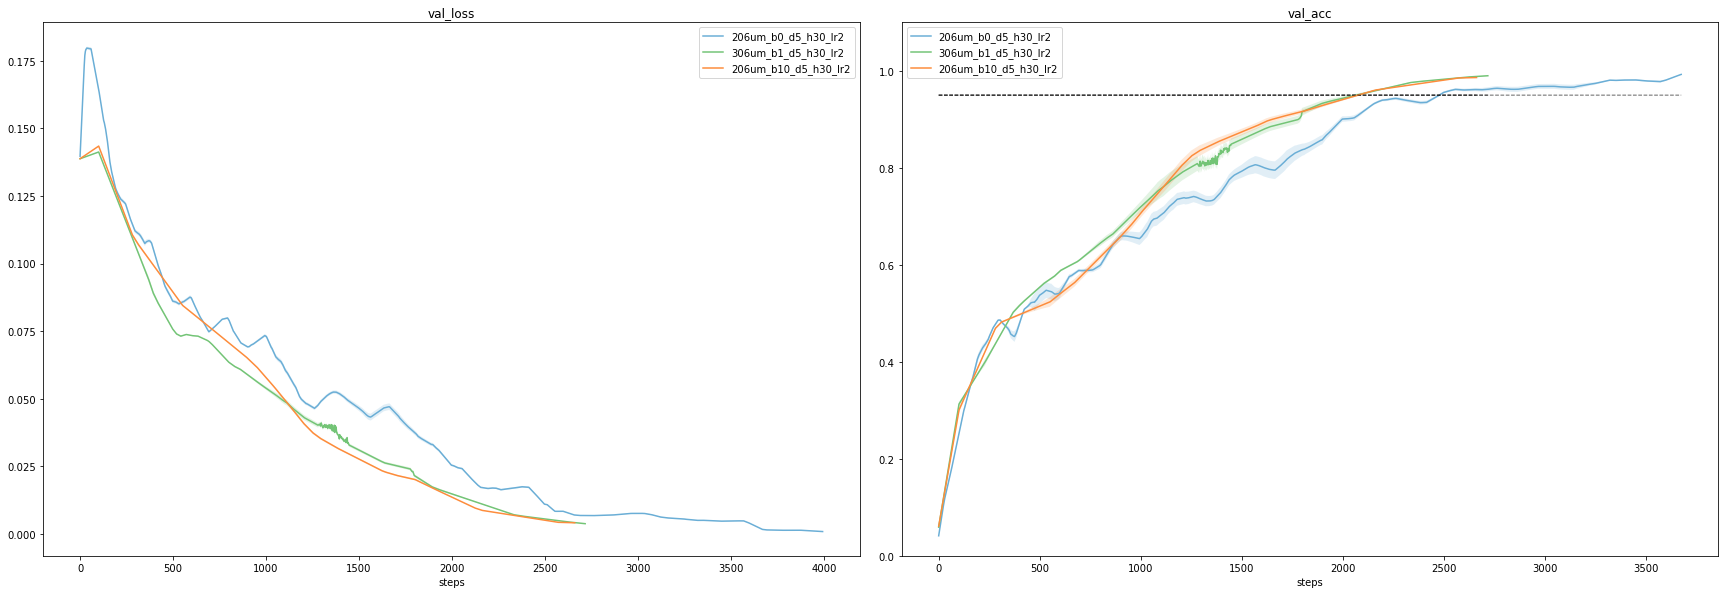

#logged paths : 3 
2524152_0306_1918_synth_split_b0_d6_h30_lr2.0_rep0
fold_0  #logged: 684, Max_acc: 1.0 Max_step: 68300 
#folds: 1
merged_2540884_0506_1159_synth_um_b0_d6_h30_lr2.0_rep0
fold_4  #logged: 115, Max_acc: 1.0 Max_step: 9751 
fold_3  #logged: 117, Max_acc: 1.0 Max_step: 9852 
fold_2  #logged: 141, Max_acc: 1.0 Max_step: 11556 
fold_0  #logged: 112, Max_acc: 1.0 Max_step: 9364 
fold_1  #logged: 158, Max_acc: 1.0 Max_step: 12687 
#folds: 5
merged_2523969_0306_1727_synth_um_b10_d6_h30_lr2.0_rep0
fold_4  #logged: 46, Max_acc: 0.964 Max_step: 3160 
fold_3  #logged: 9, Max_acc: 0.997 Max_step: 4500 
fold_2  #logged: 28, Max_acc: 0.988 Max_step: 2890 
fold_5  #logged: 10, Max_acc: 0.989 Max_step: 3920 
fold_9  #logged: 40, Max_acc: 0.952 Max_step: 3450 
fold_0  #logged: 32, Max_acc: 0.975 Max_step: 3740 
fold_7  #logged: 16, Max_acc: 0.994 Max_step: 3880 
fold_6  #logged: 59, Max_acc: 0.966 Max_step: 2690 
fold_1  #logged: 33, Max_acc: 0.969 Max_step: 4320 
fold_8  #logged: 41, Ma

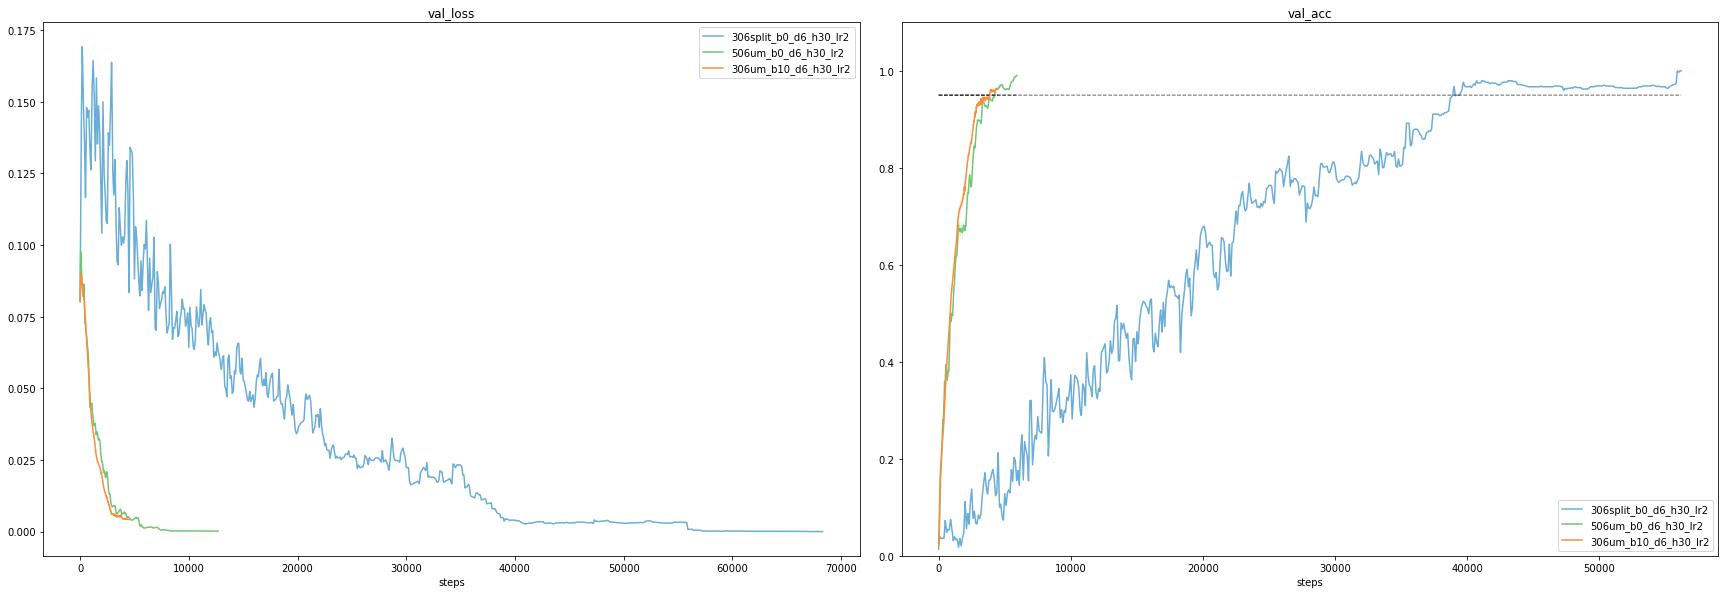

#logged paths : 6 
merged_27287606_0206_1716_synth_um_b0_d7_h250_lr2.0_rep0
fold_4  #logged: 171, Max_acc: 1.0 Max_step: 14312 
fold_3  #logged: 205, Max_acc: 1.0 Max_step: 17462 
fold_2  #logged: 241, Max_acc: 1.0 Max_step: 20677 
fold_5  #logged: 205, Max_acc: 1.0 Max_step: 17191 
fold_9  #logged: 235, Max_acc: 1.0 Max_step: 20132 
fold_0  #logged: 205, Max_acc: 1.0 Max_step: 17609 
fold_7  #logged: 264, Max_acc: 1.0 Max_step: 23048 
fold_6  #logged: 183, Max_acc: 1.0 Max_step: 15747 
fold_1  #logged: 204, Max_acc: 1.0 Max_step: 17293 
fold_8  #logged: 228, Max_acc: 1.0 Max_step: 19794 
#folds: 10
merged_27282000_0106_1256_synth_um_b1_d7_h250_lr2.0_rep1
fold_4  #logged: 9, Max_acc: 0.933 Max_step: 40623 
fold_3  #logged: 10, Max_acc: 0.895 Max_step: 53448 
fold_2  #logged: 11, Max_acc: 0.892 Max_step: 29752 
fold_5  #logged: 10, Max_acc: 0.943 Max_step: 43273 
fold_9  #logged: 9, Max_acc: 0.942 Max_step: 38489 
fold_7  #logged: 10, Max_acc: 0.913 Max_step: 38013 
fold_6  #logged: 10,

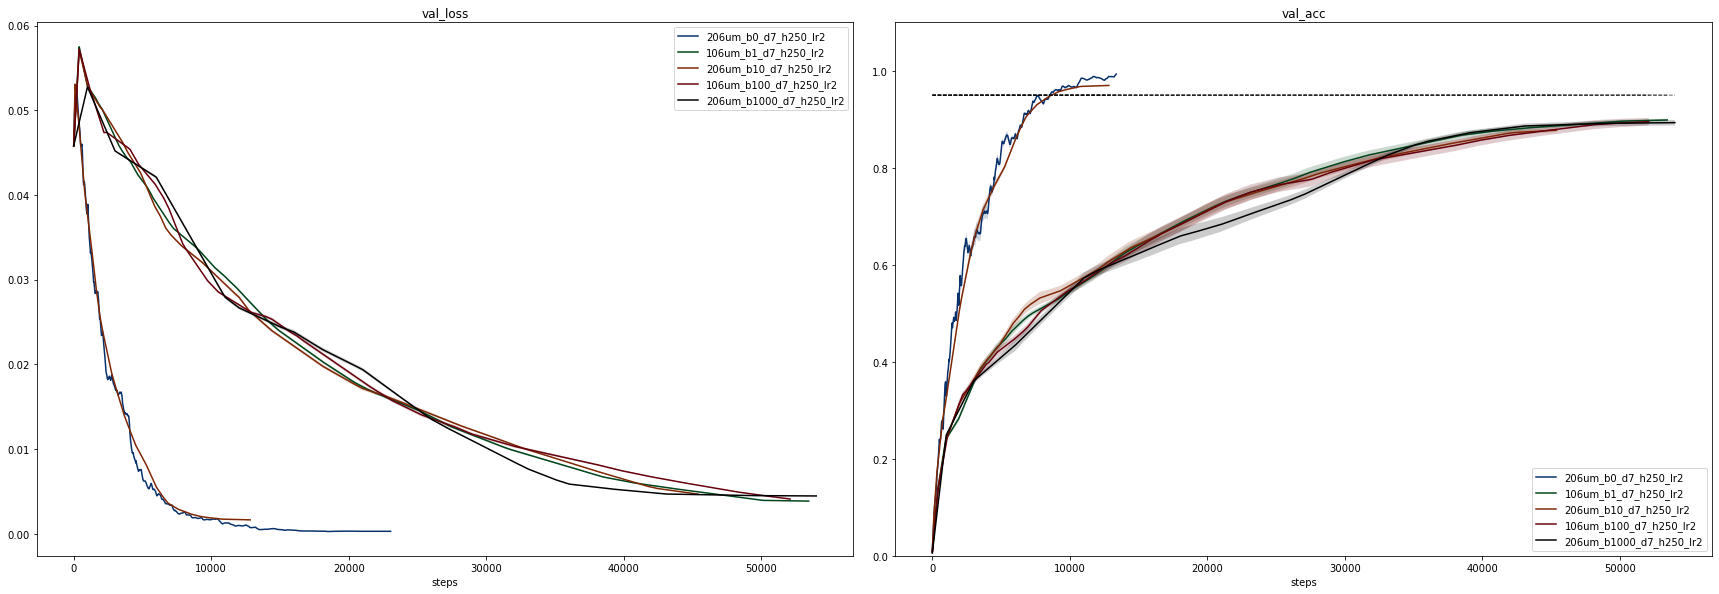

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


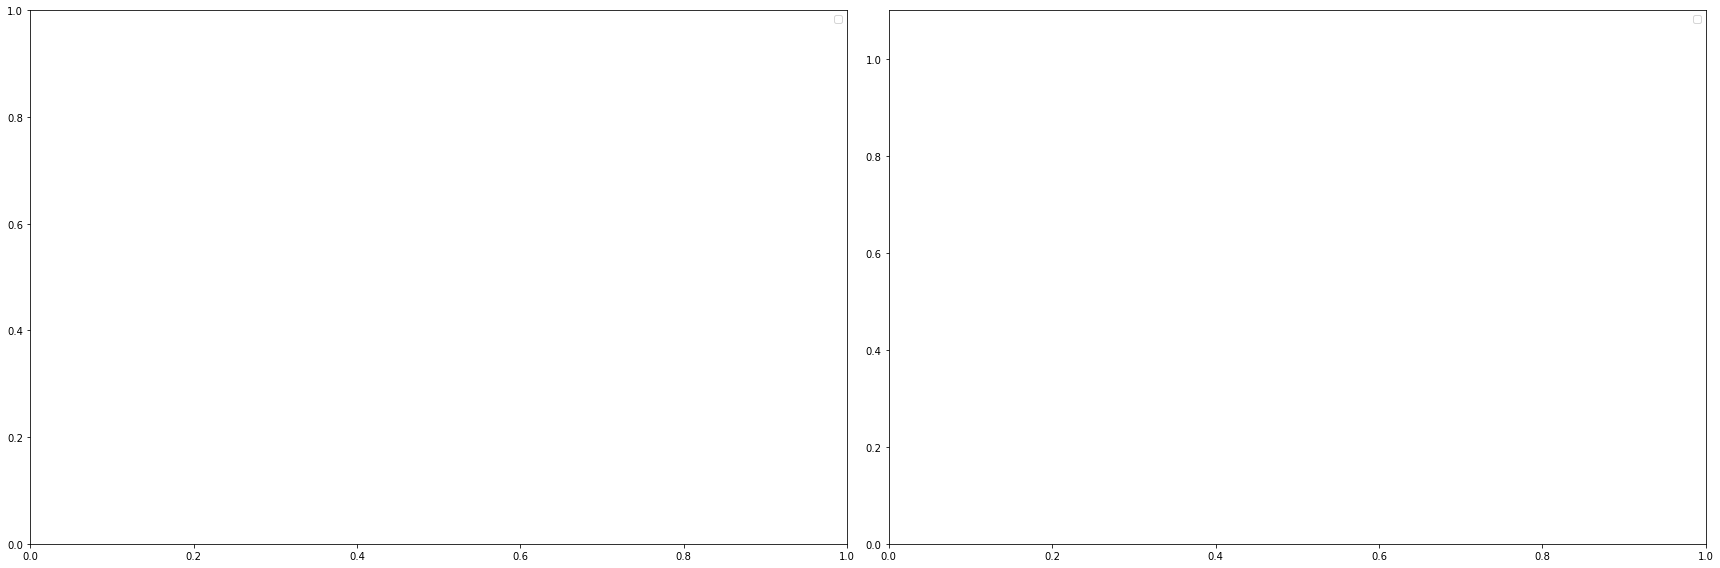

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


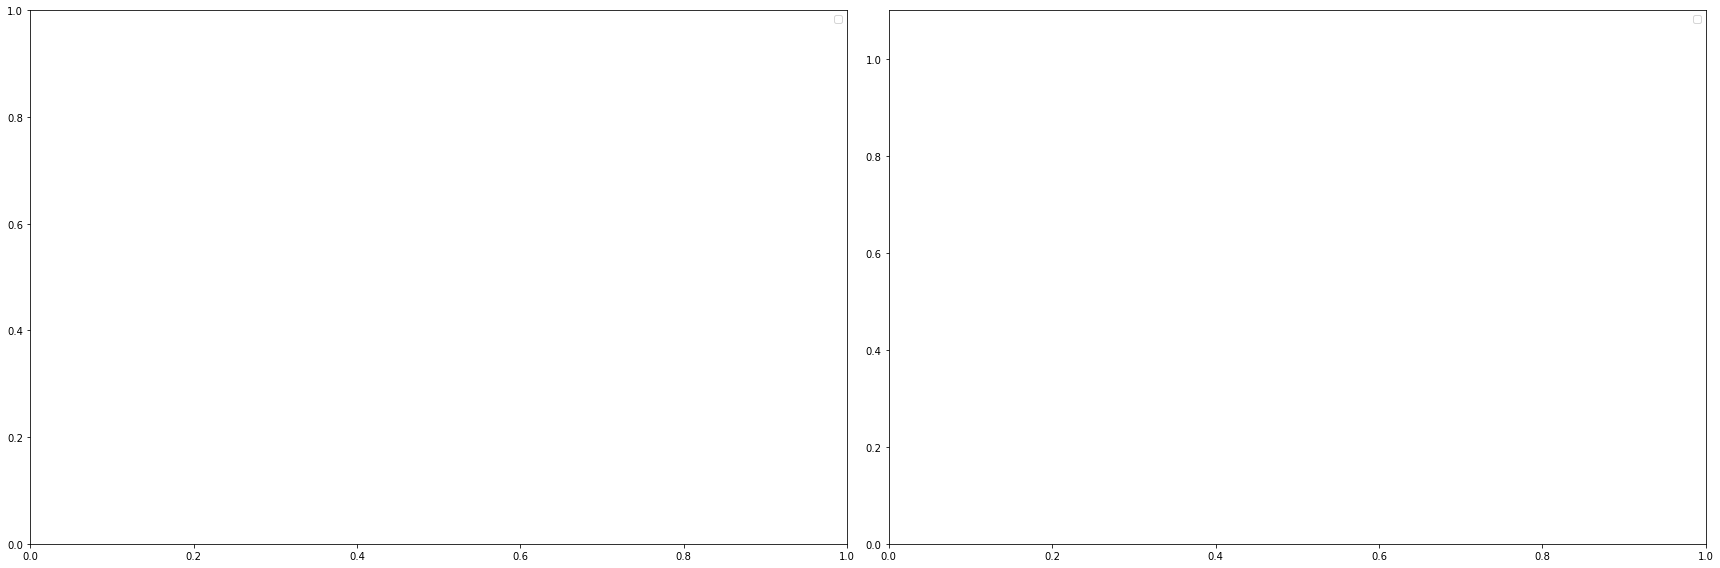

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


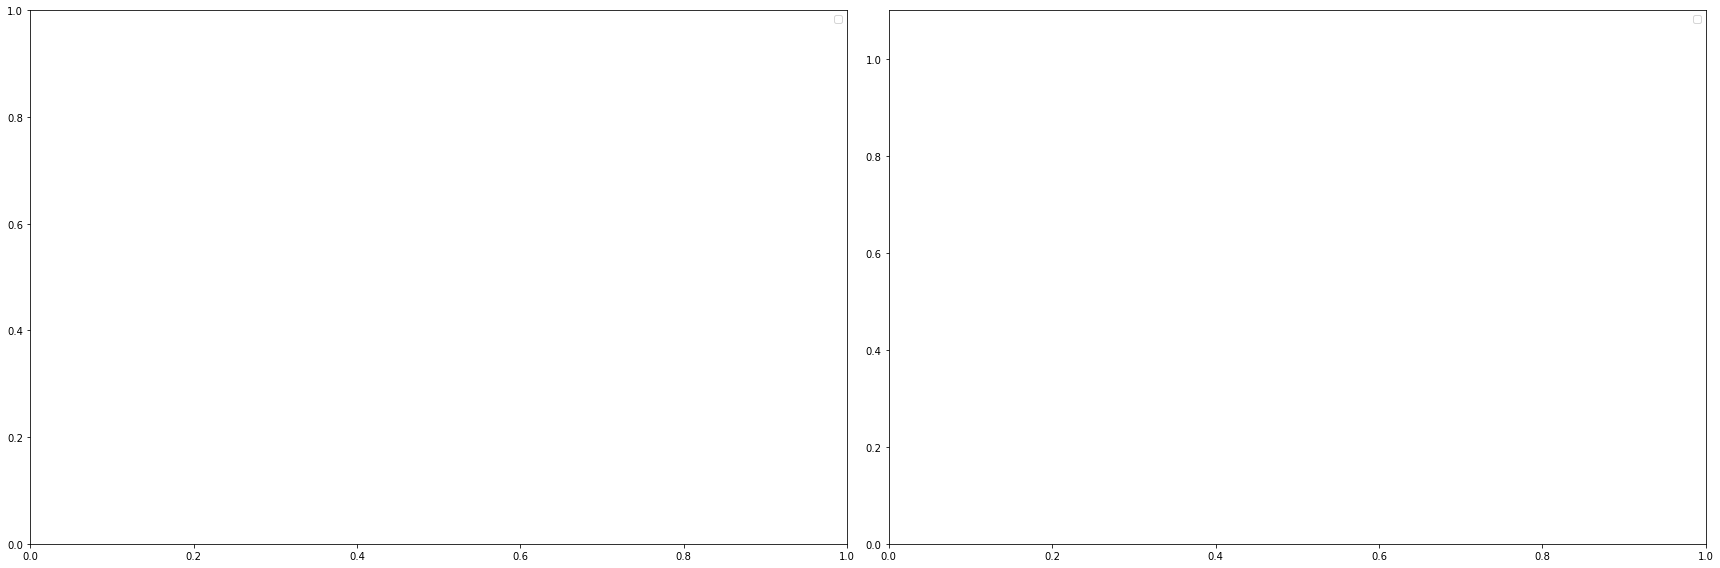

In [7]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10", 
                    "rand_b0_d5", "rand_b0_d6", "rand_b0_d7", "rand_b0_d8", "rand_b0_d9", "rand_b0_d10"]

patt = ["um_b0_d5_h30", 'um_b1_d5_h30', 'um_b10_d5_h30', 'um_b100_d5_h30', 'um_b1000_d5_h30', 'd5_h30',
                    "um_b0_d6_h30", 'um_b1_d6_h30', 'um_b10_d6_h30', 'um_b100_d6_h30', 'um_b1000_d6_h30']

patts_to_search2 = ['d5_h30_lr2','d6_h30_lr2', 'd7_h250_lr2', 'd8_h500_lr5', "d9_h500_lr5", "d10"]
#patts_to_search2 = ["d7_h250_lr2"]

for patt in patts_to_search2: plot_runs_w_regex(patt, 0.082, MERGED_LOG_PATH, verbose=True, delete_dir=False)

# Log folds merger

In [5]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    dup_hashes = np.array(dup_hashes)
    print(dup_hashes)
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = np.array([el for el in all_ckpt_dirs if "DS_Store" not in el])
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_x).group(1)) for fold_x in folds_x]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                merged_folds_nb = merged_folds_nb
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', list_folds[0]).group(1))
            source_path = join(fold, list_folds[0])
            #print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            merged_folds_nb.append(foldnb2)
            do_move=True

            # Check if file already exists
            hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
            #print(hyp_dest_path, source_path)
            if os.path.isdir(hyp_dest_path):
                print(hyp_dest_path,'exists in the destination path!')
                #rename incoming folder to part2
                new_source_path = join(source_path[:source_path.rfind('/')], f'fold_{foldnb2}_part2')
                os.rename(source_path, new_source_path)
                source_path = new_source_path
                
            if do_move:
                shutil.move(source_path, dest_path)

            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
!cd $DL_LOG_PATH
!find . -name '.DS_Store' -type f -delete
!echo DONE
merge_folds(TO_MERGE_LOG_PATH)




DONE
['um_b0_d6_h30_lr2']
[array(['2540885_0506_1159_synth_um_b0_d6_h30_lr2.0_rep1',
       '2540884_0506_1159_synth_um_b0_d6_h30_lr2.0_rep0',
       '2540887_0506_1159_synth_um_b0_d6_h30_lr2.0_rep3',
       '2540886_0506_1159_synth_um_b0_d6_h30_lr2.0_rep2',
       '2540888_0506_1159_synth_um_b0_d6_h30_lr2.0_rep4'], dtype='<U47')]
../dl_logs/to_merge/2540885_0506_1159_synth_um_b0_d6_h30_lr2.0_rep1/metrics
../dl_logs/to_merge/2540884_0506_1159_synth_um_b0_d6_h30_lr2.0_rep0/metrics
../dl_logs/to_merge/2540887_0506_1159_synth_um_b0_d6_h30_lr2.0_rep3/metrics
../dl_logs/to_merge/2540886_0506_1159_synth_um_b0_d6_h30_lr2.0_rep2/metrics
../dl_logs/to_merge/2540888_0506_1159_synth_um_b0_d6_h30_lr2.0_rep4/metrics


In [ ]:
def clean_folds(log_path=LOG_PATH):    
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [join(log_path, ckpt_path, 'metrics') for ckpt_path in all_ckpt_dirs]
    
    for ckpt in all_ckpt_dirs:
        folds = os.listdir(ckpt)
        for el in folds:
            if 'fold' not in el:
                el = join(ckpt, el)
                if os.path.isdir(el):
                    shutil.rmtree(el)
                else:
                    os.remove(el)
                
#clean_folds(log_path=DL_LOG_PATH)    

In [ ]:
a = [0,1,2,5,16,100,200,300,400]

diff = [a[i] - a[i-1] for i in range(1,len(a))]
print(diff)
np.argmax(diff)